#1. Data discretization

1.1 Loading data

In [1]:
# import pandas as pd
# from sklearn import datasets

# diabetes = datasets.load_diabetes()
# df = pd.DataFrame(diabetes.data)
# df.columns = diabetes.feature_names
# df['diabetes_measure'] = diabetes.target
# y = df['diabetes_measure']
# X = df.drop(columns=['diabetes_measure', 'sex', 's1'])
# # чтобы было видно пики
# X = X * 100

import pandas as pd

df = pd.read_csv('song_data.csv')
df.info()
df.drop(df.tail(10000).index, inplace=True)
y = df['song_popularity']
X = df.drop(columns=['song_popularity', 'loudness', 'song_name', 'audio_mode', 'time_signature', 'speechiness', 'key', 'audio_valence'])
X = X.astype('float')

 # чтобы было видно пики
X['acousticness'] = X['acousticness'] * 100
X['danceability'] = X['danceability'] * 100
X['energy'] = X['energy'] * 100
X['instrumentalness'] = X['instrumentalness'] * 100
X['liveness'] = X['liveness'] * 100

print(X.info())
print(y.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB
<class 'pandas.core.frame.Data

1.2 Clustering each feature

In [2]:
from sklearn.cluster import KMeans

models = {}
labels = {}

n_clusters = 4

for col in X.columns:
  model = KMeans(n_clusters = n_clusters)
  model.fit(X[[col]])
  centers = model.cluster_centers_.tolist()
  centers = sum(centers, [])
  centers = sorted(centers)
  models[col] = centers
  labels[col] = model.labels_

models

{'song_duration_ms': [161398.9235668796,
  217804.31576425486,
  285788.0269378786,
  457604.1791907518],
 'acousticness': [4.434599402914749,
  26.894468313641244,
  54.54164012738858,
  84.07319013524254],
 'danceability': [33.32670474516697,
  52.78737373737376,
  67.56197831087745,
  82.80143464399573],
 'energy': [24.462749598715973,
  50.08550308008213,
  69.42949395770391,
  87.92166799680783],
 'instrumentalness': [0.39096573903458687,
  21.83133159268929,
  55.40925110132158,
  86.37687861271674],
 'liveness': [9.81428285766224,
  20.579366940211024,
  35.629688747007194,
  67.62026666666662],
 'tempo': [90.22475079086117,
  119.41642392026579,
  142.33104073319754,
  174.3842992125984]}

1.3 Storing clustered data

In [3]:
import pandas as pd

X_clust = pd.DataFrame(data = labels)
X_clust.head() 

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,tempo
0,1,1,0,3,0,0,1
1,0,1,0,0,0,0,0
2,0,1,1,1,2,3,0
3,0,1,0,0,0,0,0
4,0,1,0,3,0,0,1


1.4 Clustering target value

In [4]:
model = KMeans(n_clusters=n_clusters)
model.fit(y.to_frame())
y_centers = model.cluster_centers_.tolist()
y_centers = sum(y_centers, [])
y_centers = sorted(y_centers)
y_labels = model.labels_

y_centers

[15.13844870725621, 41.3445887445889, 59.54936872774374, 77.29056772463137]

#2. Fuzzy modelling

2.1 Fuzzylogic package

In [5]:
!pip install fuzzylogic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from fuzzylogic.functions import S, R, triangular

def make_fuzzy_set(col_min, col_max, center):
  if col_min == center:
    return S(col_min, col_max)
  elif col_max == center:
    return R(col_min, col_max)
  else:
    return triangular(col_min, col_max, c=center)

2.2 Creating fuzzy variables

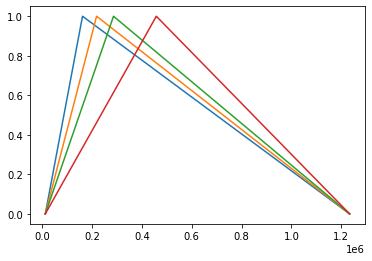

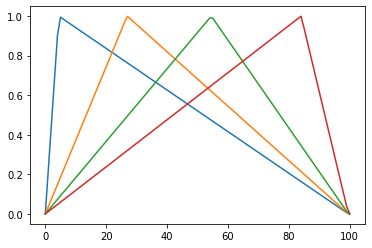

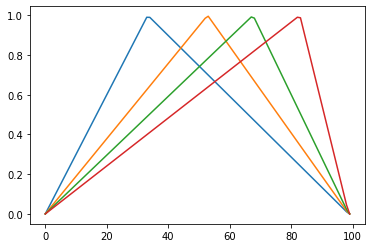

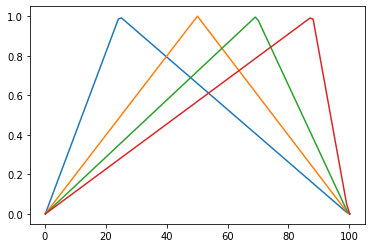

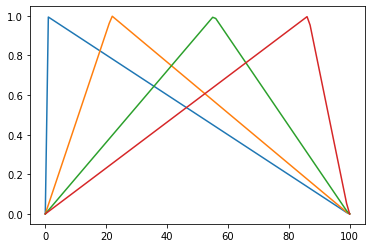

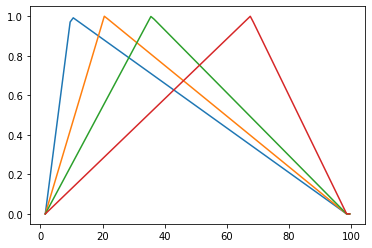

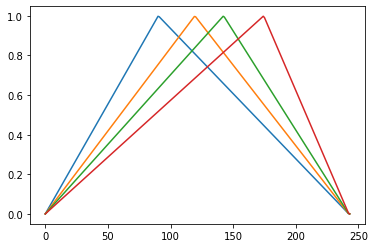

In [7]:
from fuzzylogic.classes import Domain
from matplotlib import pyplot as plt

for key, value in models.items():
  plt.figure()
  X_col = X[key]
  col_min = X_col.min()
  col_max = X_col.max()
  exec(f'{key} = Domain(key, col_min, col_max)')
  for i, rank in enumerate(['low', 'lower_than_middle', 'higher_than_middle', 'high']):
     exec(f'{key}.{rank} = make_fuzzy_set(col_min, col_max, value[{i}])')
     exec(f'{key}.{rank}.plot()')

2.3 Creating fuzzy variable for target variable

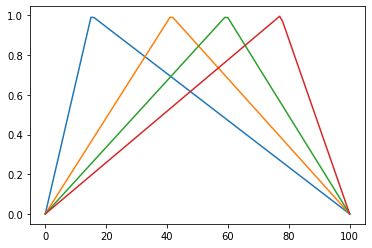

In [8]:
y_min = y.min()
y_max = y.max()
exec(f'{y.name} = Domain(y.name, y_min, y_max)')
for i, rank in enumerate(['low', 'lower_than_middle', 'higher_than_middle', 'high']):
  exec(f'{y.name}.{rank} = make_fuzzy_set(y_min, y_max, y_centers[{i}])')
  exec(f'{y.name}.{rank}.plot()')


#3. Rules learning

3.1 Fitting naive bayes

In [9]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_clust, y_labels)

model.feature_log_prob_

array([[-2.02292068, -1.70539502, -1.8418045 , -1.6588328 , -3.1698768 ,
        -2.24532046, -1.66475875],
       [-2.16430827, -1.62774002, -1.86851021, -1.60109566, -3.38405612,
        -2.22304295, -1.65768237],
       [-2.08077399, -1.67679146, -1.86997296, -1.70142473, -3.15566975,
        -2.19257495, -1.62250561],
       [-2.27945376, -1.59303649, -1.8263606 , -1.57689974, -4.23948757,
        -2.17311811, -1.61695439]])

3.2 Sampling feature combinations

In [10]:
from itertools import product

X_comb = []
for comb in product(*len(X_clust.columns)*[[0, 1, 2, 3]]):  # n_cluster
  X_comb.append(comb)
X_comb = pd.DataFrame(X_comb, columns = X_clust.columns)

X_comb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16384 entries, 0 to 16383
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   song_duration_ms  16384 non-null  int64
 1   acousticness      16384 non-null  int64
 2   danceability      16384 non-null  int64
 3   energy            16384 non-null  int64
 4   instrumentalness  16384 non-null  int64
 5   liveness          16384 non-null  int64
 6   tempo             16384 non-null  int64
dtypes: int64(7)
memory usage: 896.1 KB


3.3 Predicting labels for sampled combinations

In [11]:
preds = model.predict(X_comb)
result = X_comb.copy()
result['label'] = preds
result.to_csv('data_+_labels.csv')

preds[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

#4. Fuzzy inference

4.1 Mapping labels to fuzzy sets

In [12]:
map = { 0: 'low',
        1: 'lower_than_middle',
        2: 'higher_than_middle',
        3: 'high'}

4.2 Composing inference rules from sampled feature combinations and predicted labels

In [13]:
from fuzzylogic.classes import Rule

rules = []
for i, row in X_comb.iterrows():
  cond = []
  for col in X_comb.columns:
    cond.append('.'.join([col, map[row[col]]]))
  cond = ', '.join(cond)
  cons = '.'.join([y.name, map[preds[i]]])
  rules.append(f'({cond}): {cons}')

rules = eval('Rule({' + ',\n'.join(rules) + ',})')

rules

4.3 Formatting input data for inference

In [14]:
X_test = X[:200]
values = []
for i, row in X_test.iterrows():
  value = {}
  for col in X_test.columns:
    value[eval(col)] = row[col]
  values.append(value)

values[:5]

[{Domain('song_duration_ms', 12000.0, 1233666.0, res=1, sets={'low': Set(<function triangular.<locals>.f at 0x7fa0f71635e0>), 'lower_than_middle': Set(<function triangular.<locals>.f at 0x7fa0f4b1cca0>), 'higher_than_middle': Set(<function triangular.<locals>.f at 0x7fa0f4de05e0>), 'high': Set(<function triangular.<locals>.f at 0x7fa0f4de0c10>)}): 262333.0,
  Domain('acousticness', 0.000102, 99.6, res=1, sets={'low': Set(<function triangular.<locals>.f at 0x7fa0f4f2c940>), 'lower_than_middle': Set(<function triangular.<locals>.f at 0x7fa0f4abf0d0>), 'higher_than_middle': Set(<function triangular.<locals>.f at 0x7fa0f4abf820>), 'high': Set(<function triangular.<locals>.f at 0x7fa0f4ac5040>)}): 0.5519999999999999,
  Domain('danceability', 0.0, 98.7, res=1, sets={'low': Set(<function triangular.<locals>.f at 0x7fa0f4ac5ca0>), 'lower_than_middle': Set(<function triangular.<locals>.f at 0x7fa0f6f7d310>), 'higher_than_middle': Set(<function triangular.<locals>.f at 0x7fa0f6f7da60>), 'high': 

4.4 Running fuzzy inference

In [15]:
preds = [rules(x) for x in values]

preds[:10]

[47.07491924724243,
 None,
 41.26416996365011,
 45.55797023764133,
 None,
 47.12752606484733,
 43.014013252779165,
 44.756494750365306,
 None,
 42.16873253757218]

#5. Comparing accuracy

5.1 Matching inference result with true labels

In [16]:
y_test = y[:200]
df_test = pd.DataFrame(data = {'y_pred': preds, 'y_true': y_test})
df_test = df_test.dropna()

df_test

,y_pred,y_true
0,47.074919,73
2,41.264170,76
3,45.557970,74
5,47.127526,80
6,43.014013,81
...,...,...
185,47.127526,81
188,47.127526,63
193,47.127526,68
194,47.127526,73


5.2 MSE for fuzzy inference

In [17]:
from sklearn.metrics import mean_squared_error

mean_squared_error(df_test['y_true'], df_test['y_pred'])

676.0383306836792

5.3 MSE for linear regression



In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)
preds = model.predict(X_test)

mean_squared_error(y_test, preds)

383.6534928158349